<a href="https://colab.research.google.com/github/mbarte/AMD/blob/main/GCCategorical_MS_AMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GALAXY CLASSIFICATION TASK - MODEL SELECTION**
**RUN W/ CPU, HIGH RAM**

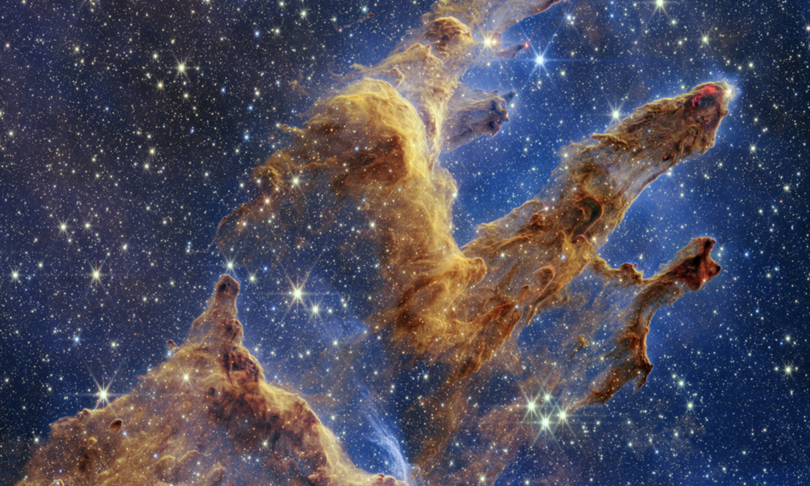

In this notebook we try to improve on the results obtained in the main notebook. In order to achieve a good result and see how to properly select the model to work with, we:
- Stratify labels
- Perform GridSearch on dropout rate and batch size (interesting to do: optimiser, loss). 

We don't include the learning rate in the Gridsearch because we control it with CallBacks

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


Since the great memory demand by GridSearch, it is reccomended to use a high-RAM runtime

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Import the necessary libraries

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
from numpy import asarray
import os
import copy
import time
import itertools
import h5py
from PIL import Image
import cv2
from random import sample, seed

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import PIL #import pillow 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers, metrics, losses, callbacks, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
strategy = tf.distribute.get_strategy()
strategy

# Fully automatic import [Run this to download and unzip the dataset]

In [ ]:
os.environ['KAGGLE_USERNAME'] = "michelebarte" 
os.environ['KAGGLE_KEY'] = "85bdd7673d63f1cd611f2e4cab0e1f6e" 

#Download
!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

print("Downloading done!")

100% 1.77G/1.77G [00:57<00:00, 37.1MB/s]
100% 1.77G/1.77G [00:57<00:00, 33.0MB/s]


In [ ]:
#Unzip
start = time.time()

!unzip /content/galaxy-zoo-the-galaxy-challenge.zip                             #-d /content/<folder name> to create a specific folder 

end = time.time()
print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

Archive:  /content/galaxy-zoo-the-galaxy-challenge.zip
  inflating: all_ones_benchmark.zip  
  inflating: all_zeros_benchmark.zip  
  inflating: central_pixel_benchmark.zip  
  inflating: images_test_rev1.zip    
  inflating: images_training_rev1.zip  
  inflating: training_solutions_rev1.zip  
Unzipping done!
The process took 0.00 hours.


In [ ]:
%%capture                                                                       
#suppress the "inflating filename..." output

start = time.time()

!unzip /content/images_training_rev1.zip                                        #unzip training data
!unzip /content/images_test_rev1.zip                                            #unzip testing data
!unzip /content/training_solutions_rev1.zip                                     #unzip training labels

end = time.time()

print("Unzipping done!")
print("The process took {:.2f} hours.".format((end - start)/3600))

# Functions

In [ ]:
BATCH_SIZE = 100                                                           
#we have less data here, smaller batch 

AUTOTUNE = tf.data.AUTOTUNE                                                     #efficiency reason

In [ ]:
path = "/content/images_training_rev1/"

- Function to turn to categorical framework - in this model selection notebook I opted for a very small number of classes because in order not to use all the RAM while performing a GridSearch I had to use less data, therefore I also had to reduce the number of classes.

In [ ]:
def to_categorical(labels):
  '''
  takes the labels as an input and convert the dataframe into a dictionary containing 26 classes for a categorical classification problem
  '''
  lb = labels.iloc[:,1:]   #values only
  id = labels.iloc[:,0]    #id's only

  class1 = lb.iloc[:,0:3]
  class2 = lb.iloc[:,3:5]
  class3 = lb.iloc[:,5:7]
  class4 = lb.iloc[:,7:9]
  class5 = lb.iloc[:,9:13]
  class6 = lb.iloc[:,13:15]
  class7 = lb.iloc[:,15:18]
  class8 = lb.iloc[:,18:25]
  class9 = lb.iloc[:,25:28]
  class10 = lb.iloc[:,28:31]
  class11 = lb.iloc[:,31:37]

  cat_labels = {}                                                             #dictionary storing galaxyID: categorical label
  #for i in labels["GalaxyID"]:
  for i in range(len(labels)):
    #---------------------------------------------------------------------------
    
    if class1.iloc[i].idxmax() == "Class1.3":  #se non è nè tonda nè a spirale
      cat_labels[id[i]] = "Other"   #non è una galassia 
    #---------------------------------------------------------------------------
    
    elif class1.iloc[i].idxmax() == "Class1.1":    #se è smooth 
      
      #-------------------------------------------------------------------------
      if class6.iloc[i].idxmax() == "Class6.2":  #se non ha features aggiuntive
        cat_labels[id[i]] ="Smooth"
      else:  
          cat_labels[id[i]] ="Other"
    
    #---------------------------------------------------------------------------
    elif class1.iloc[i].idxmax() == "Class1.2":    #galassia, ma non smooth
      if class6.iloc[i].idxmax() == "Class6.2":  #se non ha features aggiuntive
        cat_labels[id[i]] = "Disc/Spiral"
      else:  
        cat_labels[id[i]] ="Other"
      

  return cat_labels


In [ ]:
def to_cat(labels):
  '''
  takes the labels as an input and convert the dataframe into a dictionary containing 26 classes for a categorical classification problem
  '''
  lb = labels.iloc[:,1:]   #values only
  id = labels.iloc[:,0]    #id's only

  class1 = lb.iloc[:,0:3]
  class2 = lb.iloc[:,3:5]
  class3 = lb.iloc[:,5:7]
  class4 = lb.iloc[:,7:9]
  class5 = lb.iloc[:,9:13]
  class6 = lb.iloc[:,13:15]
  class7 = lb.iloc[:,15:18]
  class8 = lb.iloc[:,18:25]
  class9 = lb.iloc[:,25:28]
  class10 = lb.iloc[:,28:31]
  class11 = lb.iloc[:,31:37]

  cat_labels = {}                                                               #dictionary storing galaxyID: categorical label
  #for i in labels["GalaxyID"]:
  for i in range(len(labels)):
    #---------------------------------------------------------------------------
    if class1.iloc[i].idxmax() == "Class1.3":  #se non è nè tonda nè a spirale
      cat_labels[id[i]] = "Other"   #non è una galassia
    #---------------------------------------------------------------------------
    elif class1.iloc[i].idxmax() == "Class1.1":    #se è smooth
      if class6.iloc[i].idxmax() == "Class6.2":  #se non ha features aggiuntive
        cat_labels[id[i]] ="Elliptical"        

      elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
        cat_labels[id[i]] = "Other"
      elif class8.iloc[i].idxmax() == "Class8.1":
        cat_labels[id[i]] = "Other"
      elif class8.iloc[i].idxmax() == "Class8.2":
        cat_labels[id[i]]= "Other"
      elif class8.iloc[i].idxmax() == "Class8.3":
        cat_labels[id[i]] = "Other"
      elif class8.iloc[i].idxmax() == "Class8.4":
        cat_labels[id[i]] = "Other"
      elif class8.iloc[i].idxmax() == "Class8.5":
        cat_labels[id[i]] = "Other"
      elif class8.iloc[i].idxmax() == "Class8.6":
        cat_labels[id[i]] = "Other"
    #---------------------------------------------------------------------------
    elif class1.iloc[i].idxmax() == "Class1.2":    #galassia, ma non smooth
      #-------------------------------------------------------------------------
      if class2.iloc[i].idxmax() == "Class2.1":    # se è edge on
          if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
            cat_labels[id[i]] = "Elliptical"    

          elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.1":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.2":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.3":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.4":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.5":
            cat_labels[id[i]] = "Other"
          elif class8.iloc[i].idxmax() == "Class8.6":
            cat_labels[id[i]] = "Other"
      #-------------------------------------------------------------------------
      if class2.iloc[i].idxmax() == "Class2.2":    # se non è edge on
        #-----------------------------------------------------------------------
        if class4.iloc[i].idxmax() == "Class4.2":  #se non ha bracci
            if class6.iloc[i].idxmax() == "Class6.2":   #se non ha features aggiuntive
              cat_labels[id[i]] = "Elliptical"     #disc edge on

            elif class8.iloc[i].idxmax() == "Class8.1":   #se ha features aggiuntive
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.1":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.2":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.3":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.4":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.5":
              cat_labels[id[i]] = "Other"
            elif class8.iloc[i].idxmax() == "Class8.6":
              cat_labels[id[i]] = "Other"
        #-----------------------------------------------------------------------    
        elif class4.iloc[i].idxmax() == "Class4.1":  #se ha bracci
          #---------------------------------------------------------------------
          cat_labels[id[i]] = "Spiral"    
              
  return cat_labels

#TODO: Future work: re-write this function in an efficient way

- Functions to prepare the datasets

In [ ]:
#Create images (X) and labels datasets
def my_X_train(final, X_train):
  '''
  takes the dataset with id's and OneHotEncoded labels 
  X_train containing id's turns it into a dataset with corresponding images
  '''
  images = []
  
  for id in X_train["GalaxyID"]:
    path = "/content/images_training_rev1/"
    extension = ".jpg"
    img = Image.open(path + str(id) + extension)
    img = asarray(img)
    img = img[137:287, 137:287]                                                 #retain the central 150x150 pixels to exclude other galaxies
    img = cv2.resize(img, (100,100))                                            #resize to make training faster
    norm = np.zeros((100,100))
    img = cv2.normalize(img, norm, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    images.append(img) 
  images = np.array(images)

  return images
    

def my_y_train(final, y_train):

  labels = []
  for id in y_train["GalaxyID"]:
    row = final.loc[final["GalaxyID"] == id]                                      #retrieve the corresponding row in the labels dataframe
    lbl = np.asarray(row.iloc[0,:3].values, dtype = np.uint8)
    labels.append(lbl)
  labels = np.array(labels)     #required to make vgg work
  
  return labels

- Function to schedule the learning rate decrease

In [ ]:
def decay_schedule(epoch, lr):
    return lr * 0.8 if (epoch % 10 == 0) and (epoch != 0) else lr

- Function to buil the CNN model

In [ ]:
def cnn(dropout_rate = 0.2):
    input_shape = (100,100,3)
    model = tf.keras.models.Sequential(name="Selection_Model", layers=[
        layers.Conv2D(filters=16,kernel_size=(3, 3),padding = "valid", activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=32,kernel_size=(5, 5), padding = "valid", activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Dropout(0.1),
        layers.Conv2D(filters=64,kernel_size=(3, 3), padding = "valid",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(filters=128,kernel_size=(3, 3), padding = "valid",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

    return model

# Preprocessing

The first part is analogous at the main notebook. But in this case we will work with half of the available data, because GridSearch is computationally heavy and using all the images would require an excessive amount of RAM

In [ ]:
files_list = os.listdir("/content/images_training_rev1/")                       #easier to work with strings instead of Tensors in this case

#subsample
seed(123)
sample_size = int(len(files_list)*0.2)                                          #work with approximately 12300 images
files_list = sample(files_list, sample_size)                                    
print("We are now working with: ", len(files_list), " files")
files_list[:3]

We are now working with:  12315  files


['992427.jpg', '961426.jpg', '445750.jpg']

In [ ]:
#Inspect the training labels
labels = pd.read_csv("/content/training_solutions_rev1.zip")
print("The shape of the dataframe is: ", labels.shape)
labels.head()

#labels.info()   #no null values

The shape of the dataframe is:  (61578, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027227,0.000000,0.027227,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
#Retrieve labels corresponding to the images drawn in the sample
ids = []
for file in files_list:                                    
  id = int(file[:-4])
  ids.append(id)

labels = labels[labels["GalaxyID"].isin(ids)]

In [ ]:
labels.reset_index(inplace = True, drop = True)

In [ ]:
print("The shape of the dataframe is: ", labels.shape) 
labels.head()

The shape of the dataframe is:  (12315, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.000000,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,100335,0.165002,0.834998,0.000000,0.235325,0.599673,0.148674,0.450999,0.378226,0.221447,0.301093,0.139672,0.158908,0.000000,0.313408,0.686592,0.000000,0.123752,0.041251,0.024132,0.000000,0.000000,0.216878,0.072397,0.000000,0.0,0.078442,0.078442,0.078442,0.047278,0.236391,0.094556,0.141835,0.094556,0.0,0.0,0.0,0.141835
2,100458,0.820908,0.081499,0.097593,0.000000,0.081499,0.000000,0.081499,0.000000,0.081499,0.000000,0.000000,0.081499,0.000000,0.921161,0.078839,0.355112,0.465796,0.000000,0.000000,0.026714,0.081062,0.000000,0.244108,0.569277,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100479,0.841554,0.158446,0.000000,0.000000,0.158446,0.000000,0.158446,0.087393,0.071053,0.000000,0.061897,0.053651,0.042898,0.205023,0.794977,0.352775,0.488779,0.000000,0.000000,0.041005,0.123014,0.041005,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.087393,0.000000,0.000000,0.0,0.0,0.0,0.087393
4,100561,0.288297,0.701849,0.009854,0.112970,0.588879,0.000000,0.588879,0.160232,0.428647,0.061743,0.184695,0.184571,0.157870,0.927608,0.072392,0.112016,0.176281,0.000000,0.000000,0.022285,0.022285,0.000000,0.248848,0.634191,0.0,0.112970,0.000000,0.000000,0.094613,0.065619,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.160232


In [ ]:
#Convert into categorical labels (3 classes)
cat_labels = to_cat(labels)

In [ ]:
#Create a dataframe from the dictionary
categorical_data = pd.DataFrame.from_dict(cat_labels, orient = "index", columns = ["LABEL"])

#Create a column containing the index, namely the GalaxyID and reset the index to count the rows
categorical_data["GalaxyID"] = categorical_data.index
categorical_data.reset_index(drop=True)
categorical_data.head() 

,LABEL,GalaxyID
100053,Elliptical,100053
100335,Spiral,100335
100458,Other,100458
100479,Elliptical,100479
100561,Other,100561


In [ ]:
#Create a list with the ID of the galaxies without categorical label
missing = []
for file in files_list:
  id = int(file[:-4])      
  if id not in categorical_data["GalaxyID"]:                                  
    missing.append(id)

print("The number of the galaxies without categorical label is the difference between the total number of files and the number of galaxies in categorical_data: ",
      len(missing) == len(files_list) - len(categorical_data))
missing[:10]

#TODO: make it more efficient

The number of the galaxies without categorical label is the difference between the total number of files and the number of galaxies in categorical_data:  True


[517233,
 966558,
 988425,
 527085,
 317143,
 265206,
 421296,
 819536,
 330125,
 868815]

In [ ]:
#retrieve the name of the file starting from the ID and delete it from the list of files that will be used to train and test the model
print("Total number of elements before: ", len(files_list))
for i in range(len(missing)):
  filename = str(missing[i]) + ".jpg"
  files_list.remove(filename)
  print(filename, "removed successfully!")
print("Total number of elements after: ", len(files_list))

Total number of elements before:  12315
517233.jpg removed successfully!
966558.jpg removed successfully!
988425.jpg removed successfully!
527085.jpg removed successfully!
317143.jpg removed successfully!
265206.jpg removed successfully!
421296.jpg removed successfully!
819536.jpg removed successfully!
330125.jpg removed successfully!
868815.jpg removed successfully!
390910.jpg removed successfully!
Total number of elements after:  12304


Encode labels

In [ ]:
#Create the dummy variables
pd.set_option('display.max_columns', False)
one_hot = pd.get_dummies(categorical_data['LABEL'])
one_hot.head()

,Elliptical,Other,Spiral
100053,1,0,0
100335,0,0,1
100458,0,1,0
100479,1,0,0
100561,0,1,0


In [ ]:
#Obtain the final dataset containing: GalaxyID and 26 columns corresponding to thge 26 classes and 0-1 entries to encode the class each galaxy belongs to
final = pd.merge(one_hot, categorical_data, left_index =  True, right_on = "GalaxyID")
final.drop(columns="LABEL", inplace = True)
final = final.reset_index(drop=True)
final.head()

,Elliptical,Other,Spiral,GalaxyID
0,1,0,0,100053
1,0,0,1,100335
2,0,1,0,100458
3,1,0,0,100479
4,0,1,0,100561


See how they are distributed

In [ ]:
counts = pd.DataFrame(categorical_data.groupby("LABEL").count())
counts.columns = ["count"]
counts["LABEL"] = counts.index
counts.reset_index(inplace = True, drop = True)
counts

,count,LABEL
0,7999,Elliptical
1,1198,Other
2,3107,Spiral


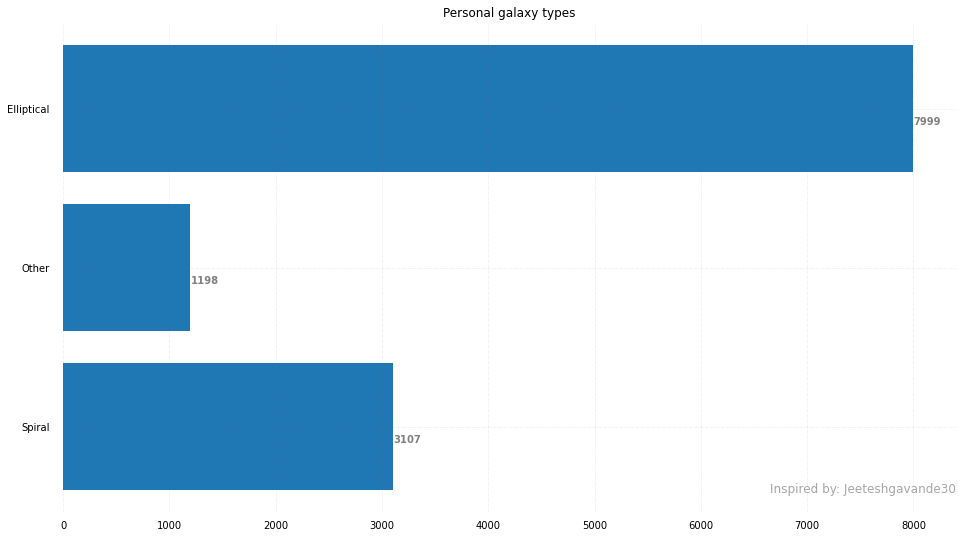

In [ ]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(counts["LABEL"], counts["count"])
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Personal galaxy types' )
 
# Add Text watermark
fig.text(0.9, 0.15, 'Inspired by: Jeeteshgavande30', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

A key observation is that even after stratifying labels, no one guarantess that batches are stratified. This issue is solved by shuffling the dataset and training for long enough, because eventually over time labels from stratified training dataset will distribute quite evenly across batches.

It seems impossible to work directly with Tensorflow to stratify labels, so we adopt an alternative approach (less efficient)

In [ ]:
#Manually stratifying labels
train = categorical_data.groupby("LABEL", group_keys = False).apply(lambda x: x.sample(frac = 0.7, random_state = 1))
remaining = categorical_data.drop(train.index)
validation = remaining.groupby("LABEL", group_keys = False).apply(lambda x: x.sample(frac = 0.7, random_state = 1))
test = remaining.drop(validation.index)

We can check that all the classes are included in the splits we created, with the same frequency of the original one

In [ ]:
validation.groupby("LABEL").count()

,GalaxyID
LABEL,
Elliptical,1680
Other,251
Spiral,652


In [ ]:
X_train = my_X_train(final, train)
y_train = my_y_train(final, train)

In [ ]:
len(X_train), len(y_train)

(8613, 8613)

In [ ]:
X_test = my_X_train(final, test)
y_test = my_y_train(final, test)

In [ ]:
len(X_test), len(y_test)

(1108, 1108)

In [ ]:
X_val = my_X_train(final, validation)
y_val = my_y_train(final, validation)

In [ ]:
len(X_val), len(y_val)

(2583, 2583)

Image example from the training set


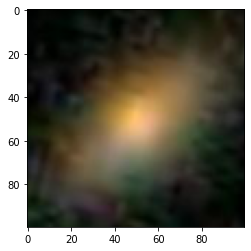

In [ ]:
#low res for didactic purposes and low computational power
print("Image example from the training set")
#plt.imshow(X_train[139])    
plt.imshow(X_train[277])

# Model selection

Once we stratified labels, we run GridSearch. We use only 3 epochs in order to spot which combination is likely to result in the best model and save time

In [ ]:
seed(123)
model = KerasClassifier(cnn, epochs =3, verbose=True)

<ipython-input-74-0cc7ab597eb6>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(cnn, epochs =3, verbose=True)


In [ ]:
batch_size = [32, 64, 128]
dropout_rate = [0.1, 0.3, 0.4]
param_grid = dict(batch_size=batch_size, dropout_rate = dropout_rate)
param_grid

{'batch_size': [32, 64, 128], 'dropout_rate': [0.1, 0.3, 0.4]}

In [ ]:
grid = GridSearchCV(estimator = model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/3
270/270 [==============================] - 54s 195ms/step - loss: 0.8496 - accuracy: 0.6625
Epoch 2/3
270/270 [==============================] - 53s 195ms/step - loss: 0.7561 - accuracy: 0.6967
Epoch 3/3
270/270 [==============================] - 54s 199ms/step - loss: 0.7331 - accuracy: 0.7100


In [ ]:
#grid_result.cv_results_

In [ ]:
#See which values of the parameters led to the best result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.579357 using {'batch_size': 32, 'dropout_rate': 0.3}
0.546616 (0.390172) with: {'batch_size': 32, 'dropout_rate': 0.1}
0.579357 (0.413141) with: {'batch_size': 32, 'dropout_rate': 0.3}
0.544294 (0.391437) with: {'batch_size': 32, 'dropout_rate': 0.4}
0.060490 (0.034559) with: {'batch_size': 64, 'dropout_rate': 0.1}
0.313712 (0.443656) with: {'batch_size': 64, 'dropout_rate': 0.3}
0.272959 (0.347035) with: {'batch_size': 64, 'dropout_rate': 0.4}
0.087194 (0.110043) with: {'batch_size': 128, 'dropout_rate': 0.1}
0.296528 (0.419355) with: {'batch_size': 128, 'dropout_rate': 0.3}
0.097411 (0.104537) with: {'batch_size': 128, 'dropout_rate': 0.4}


Build the model with the best hyperparameters

In [ ]:
selected_model = cnn(dropout_rate = 0.3)

Since classes are imbalanced, we derive balanced weights to penalise more mistakes made on the less frequent class. The formula is

weight_i = (total number of examples)/(n_classes * (number of examples in class_i))

In [ ]:
class_weights = {0: 0.513, 1: 3.426, 2: 1.321}

In [ ]:
num_epochs = 25
BATCH_SIZE = 32
# Callbacks to make the training both more efficient and faster
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

lr_scheduler = callbacks.LearningRateScheduler(decay_schedule)

early_stop = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=7)

checkpoint = callbacks.ModelCheckpoint('best_model', save_best_only=True, monitor='val_accuracy', mode='max')

callbacksInUse = [reduce_lr, lr_scheduler, early_stop, checkpoint]

#Fit the model
print('------- Training -------')
start = time.time()
history = selected_model.fit(X_train, y_train, 
                             validation_data=(X_val, y_val), 
                             batch_size=BATCH_SIZE, 
                             epochs=num_epochs, 
                             callbacks=callbacksInUse, 
                             class_weight= class_weights,                       #of paramount importance for class imbalance
                             use_multiprocessing=True, 
                             verbose=True)
end = time.time()
print("Total training took {:.2f} hours.".format((end - start)/3600))

------- Training -------
Epoch 1/25
270/270 [==============================] - ETA: 0s - loss: 1.1151 - accuracy: 0.4388

270/270 [==============================] - 60s 220ms/step - loss: 1.1151 - accuracy: 0.4388 - val_loss: 1.2820 - val_accuracy: 0.1146 - lr: 0.0100
Epoch 2/25
269/270 [============================>.] - ETA: 0s - loss: 0.9918 - accuracy: 0.5319

270/270 [==============================] - 61s 226ms/step - loss: 0.9918 - accuracy: 0.5319 - val_loss: 1.3515 - val_accuracy: 0.3027 - lr: 0.0100
Epoch 3/25
269/270 [============================>.] - ETA: 0s - loss: 0.9761 - accuracy: 0.5266

270/270 [==============================] - 60s 224ms/step - loss: 0.9760 - accuracy: 0.5268 - val_loss: 1.0795 - val_accuracy: 0.4154 - lr: 0.0100
Epoch 4/25
269/270 [============================>.] - ETA: 0s - loss: 0.9642 - accuracy: 0.5430

270/270 [==============================] - 62s 229ms/step - loss: 0.9651 - accuracy: 0.5430 - val_loss: 0.9145 - val_accuracy: 0.6233 - lr: 0.0100
Epoch 5/25
269/270 [============================>.] - ETA: 0s - loss: 0.9360 - accuracy: 0.5769

270/270 [==============================] - 65s 241ms/step - loss: 0.9356 - accuracy: 0.5772 - val_loss: 0.8776 - val_accuracy: 0.6554 - lr: 0.0100
Epoch 6/25
270/270 [==============================] - 56s 206ms/step - loss: 0.9165 - accuracy: 0.5929 - val_loss: 0.8830 - val_accuracy: 0.6477 - lr: 0.0100
Epoch 7/25
270/270 [==============================] - 56s 209ms/step - loss: 0.9132 - accuracy: 0.6014 - val_loss: 0.8797 - val_accuracy: 0.6434 - lr: 0.0100
Epoch 8/25
269/270 [============================>.] - ETA: 0s - loss: 0.8878 - accuracy: 0.6062

270/270 [==============================] - 59s 219ms/step - loss: 0.8877 - accuracy: 0.6061 - val_loss: 0.8209 - val_accuracy: 0.6752 - lr: 0.0100
Epoch 9/25
270/270 [==============================] - 57s 209ms/step - loss: 0.8944 - accuracy: 0.6071 - val_loss: 0.9289 - val_accuracy: 0.6036 - lr: 0.0100
Epoch 10/25
269/270 [============================>.] - ETA: 0s - loss: 0.8830 - accuracy: 0.6039

270/270 [==============================] - 61s 227ms/step - loss: 0.8834 - accuracy: 0.6036 - val_loss: 0.8499 - val_accuracy: 0.6841 - lr: 0.0100
Epoch 11/25
270/270 [==============================] - 59s 219ms/step - loss: 0.8669 - accuracy: 0.6285 - val_loss: 0.9513 - val_accuracy: 0.5869 - lr: 0.0016
Epoch 12/25
270/270 [==============================] - 59s 218ms/step - loss: 0.8357 - accuracy: 0.6385 - val_loss: 0.8520 - val_accuracy: 0.6531 - lr: 0.0016
Epoch 13/25
270/270 [==============================] - 57s 209ms/step - loss: 0.8325 - accuracy: 0.6427 - val_loss: 0.8073 - val_accuracy: 0.6740 - lr: 0.0016
Epoch 14/25
270/270 [==============================] - 56s 209ms/step - loss: 0.8286 - accuracy: 0.6549 - val_loss: 0.8210 - val_accuracy: 0.6671 - lr: 0.0016
Epoch 15/25
270/270 [==============================] - 58s 213ms/step - loss: 0.8211 - accuracy: 0.6459 - val_loss: 0.7853 - val_accuracy: 0.6791 - lr: 0.0016
Epoch 16/25
270/270 [==============================] - 64s

270/270 [==============================] - 58s 216ms/step - loss: 0.8110 - accuracy: 0.6605 - val_loss: 0.7191 - val_accuracy: 0.7100 - lr: 0.0016
Epoch 20/25
270/270 [==============================] - 56s 206ms/step - loss: 0.8100 - accuracy: 0.6652 - val_loss: 0.8142 - val_accuracy: 0.6640 - lr: 0.0016
Epoch 21/25
270/270 [==============================] - 56s 207ms/step - loss: 0.8131 - accuracy: 0.6549 - val_loss: 0.7325 - val_accuracy: 0.6965 - lr: 0.0013
Epoch 22/25
270/270 [==============================] - 56s 206ms/step - loss: 0.8024 - accuracy: 0.6650 - val_loss: 0.7766 - val_accuracy: 0.6814 - lr: 2.5600e-04
Epoch 23/25
270/270 [==============================] - 55s 203ms/step - loss: 0.8020 - accuracy: 0.6634 - val_loss: 0.7711 - val_accuracy: 0.6794 - lr: 2.5600e-04
Epoch 24/25
270/270 [==============================] - 55s 202ms/step - loss: 0.7991 - accuracy: 0.6662 - val_loss: 0.7455 - val_accuracy: 0.6945 - lr: 2.5600e-04
Epoch 25/25
270/270 [=========================

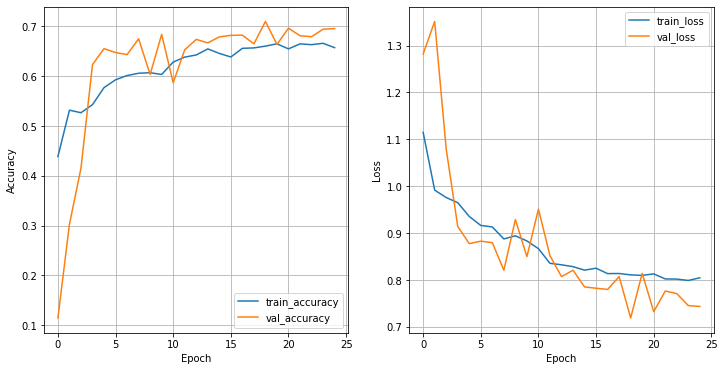

In [ ]:
# Plot learning curves
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(metrics['accuracy'], label='train_accuracy')
axes[0].plot(metrics['val_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(visible = True)
axes[1].plot(metrics['loss'], label='train_loss')
axes[1].plot(metrics['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(visible = True)
plt.show()

This is not the best result achieved. Here it is largely underfitting. Note that the validation loss might be higher because during validation the regularisation techniques are not used.

**In the report one can see the training results obtained with the best combination of parameters values, using 50% of the available data**

In [ ]:
#test accuracy 
score =selected_model.evaluate(X_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

35/35 [==============================] - 2s 47ms/step - loss: 0.7288 - accuracy: 0.6968
Test loss: 0.7288153767585754
Test accuracy: 0.6967508792877197


In [ ]:
preds = selected_model.predict(X_test)

35/35 [==============================] - 2s 49ms/step


In [ ]:
array_pred = np.argmax(preds, axis =1)
array_true = np.argmax(y_test, axis = 1)

In [ ]:
misclass = []
for num in range(len(y_test)):
    if array_pred[num] != array_true[num]:
        misclass.append(num)

Take a look at a few misclassified images

Misclassified images


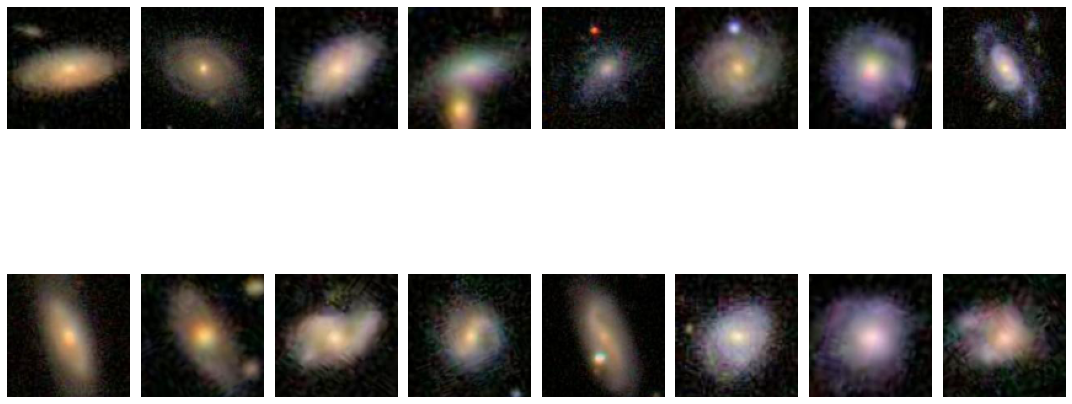

In [ ]:
print("Misclassified images")
fig = plt.figure(figsize= (15,15))
position = 1
for i in misclass[:16]:
  fig.add_subplot(2, 8, position)
  plt.imshow(X_test[i])
  plt.axis('off')
  plt.tight_layout()
  position +=1